### Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import subjects
from neuropy.utils.signal_process import filter_sig
from neuropy import plotting
from neuropy.analyses import Pf1D

### A sample run with CA1 cells, LFP, Actual position and decoded position
- something similar to Fig1C of Tang2021

In [2]:
from neuropy.utils.position_util import run_direction

sess = subjects.nsd.ratUday2[0]
# sess = subjects.sd.ratRday2[0]
# sess = subjects.nsd.ratVday3[0]
maze = sess.paradigm["maze"].flatten()
maze_pos = sess.maze
# maze_run= run_direction(maze_pos,min_distance=50,sigma=0.2,speed_thresh=(30,None))
maze_run = sess.maze_run.duration_slice(min_dur=0)
neurons = sess.neurons_stable.get_neuron_type(["pyr"])
# good_cells = neurons.firing_rate<10
# neurons = neurons[good_cells]
pf = Pf1D(
    neurons=neurons,
    position=maze_pos,
    sigma=4,
    grid_bin=2,
    epochs=maze_run["down"],
    frate_thresh=1,
    # speed_thresh=5,
)

Note: speed_thresh is ignored when epochs is provided


In [ ]:
from neuropy.plotting import plot_epochs_with_raster

_, ax = plt.subplots()

# ax.plot(maze_pos.time,maze_pos.x)
# plot_epochs(maze_run,ax=ax,collapsed=True)

In [ ]:
from neuropy.analyses.decoders import Decode1d

pf_neurons = neurons.get_by_id(pf.neuron_ids).time_slice(*maze)
decode = Decode1d(neurons=pf_neurons, ratemap=pf, bin_size=0.25)
from scipy.ndimage import gaussian_filter1d

_, ax = plt.subplots()
# ax.imshow(decode.posterior,aspect='auto',cmap='binary',vmax=0.1)
decoded_pos = gaussian_filter1d(decode.decoded_position, sigma=1)
ax.plot(np.arange(maze[0], maze[1], 0.25), decoded_pos, "k")
ax.plot(maze_pos.time, maze_pos.x)
# ax.plot(,'.')

meta NOT subset; don't know how to subset; dropped


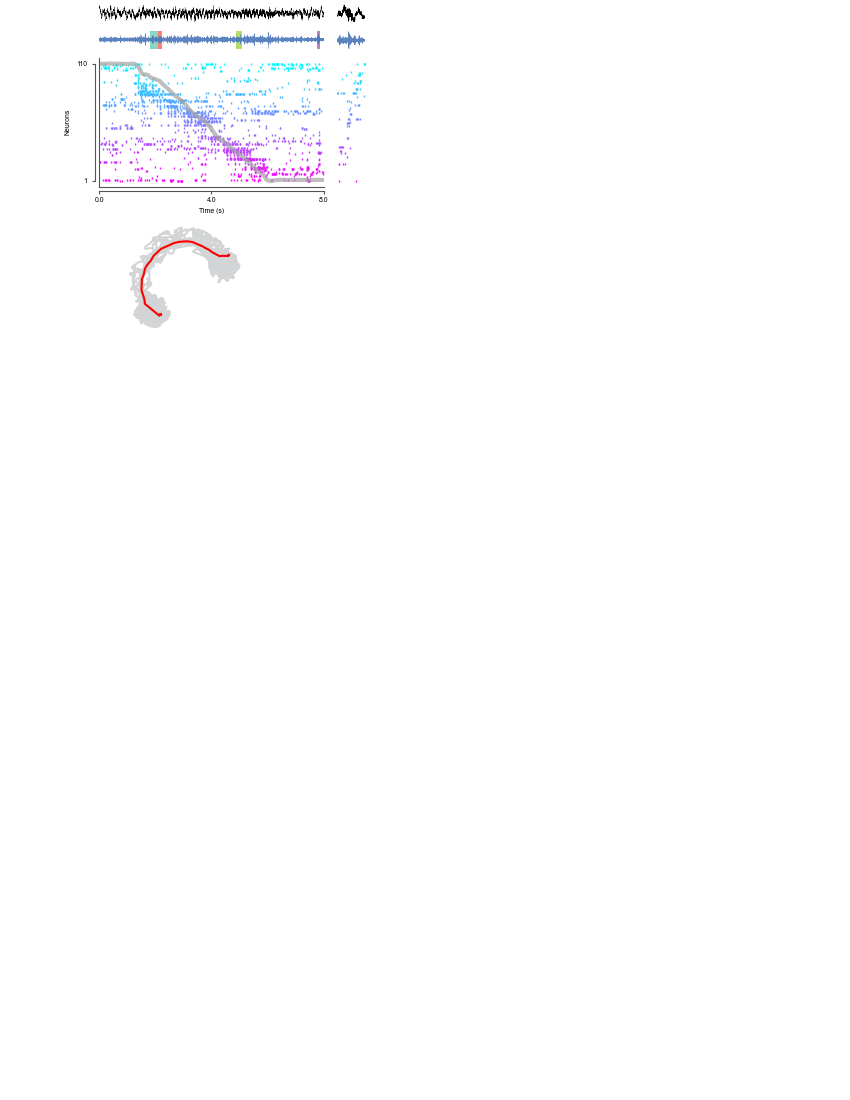

In [10]:
# ---- Choose Period-----
# RatVDay2SD
# run_epoch = [12721, 12]
# pbe = [12722.5, 12723]


# RatUDay2NSD
# run_epoch = [11419, 11430.5]
# pbe = [11420.22, 11420.5]
# run_epoch = [11162, 11172]
# pbe = [11165.5, 11165.79]
run_epoch = [10744, 10760]
# pbe = [10758.1, 10758.55]
pbe = [10753.61, 10753.87]

# RatVDay2SD
# run_epoch = [maze[0] + 1060, maze[0] + 1070]
# pbe = [maze[0] + 1060 + 4.5, maze[0] + 1060 + 4.7]


# run_epoch = maze
run_epoch = [10745.5, 10753.5]
# pbe = [maze[0]+100,maze[0]+100.5]
# pbe = [10753.6, 10753.9]
pbe = [13595.941, 13596.19]
pbe = sess.replay_radon_mua[5821].flatten()
pbe[0] = pbe[0] - 0.025
pbe[1] = pbe[1] + 0.025

# neurons_sorted = neurons.get_by_id(pf.get_sort_order("neuron_id")).time_slice(*run_epoch)
neurons_sorted = neurons.get_by_id(pf.get_sort_order("neuron_id"))
pos_epoch = maze_pos.time_slice(*run_epoch)

cmap = "cool_r"
raster_kw = dict(markersize=2, markeredgewidth=1, rasterized=True)
fig = plotting.Fig(30, 14, tick_size=2, axis_lw=0.8, fontsize=5)
subfig = fig.add_subfigure(fig.gs[0:6, 1:6])
axs = subfig.subplots(
    3, 2, gridspec_kw={"height_ratios": [1, 1, 7], "width_ratios": [8, 1]}, sharex="col"
)


# ---- Running epoch --------
channel = 72
# Raw LFP
sig_ax = axs[0, 0]
signal = sess.eegfile.get_signal(channel, *run_epoch)
sig_ax.plot(signal.time, signal.traces[0], "k", lw=0.2)
sig_ax.set_xlim(run_epoch)
sig_ax.axis("off")

# Ripple band LFP
rpl_signal = filter_sig.bandpass(signal, lf=125, hf=250)
rpl_ax = axs[1, 0]
rpl_ax.plot(signal.time, rpl_signal.traces[0], "#4a77bae8", lw=0.2)
plotting.plot_epochs(sess.pbe.time_slice(*run_epoch), ax=rpl_ax, collapsed=True)
rpl_ax.set_xlim(run_epoch)
rpl_ax.axis("off")


# raster plot
ax = axs[2, 0]
plotting.plot_raster(
    neurons_sorted.time_slice(*run_epoch), color=cmap, ax=ax, **raster_kw
)

ax.set_xticks(np.arange(0, 8.1, 4) + run_epoch[0], np.arange(0, 8.1, 4))
ax.tick_params(rotation=0)
ax.set_yticks([1, len(neurons_sorted)])
sns.despine(ax=ax, trim=True, offset=3)


# Position plot
ax2 = ax.twinx()
ax2.plot(pos_epoch.time, pos_epoch.x, color="#a3a3a3", alpha=0.7, lw=3)
ax2.set_yticks([])
xticks = np.arange(run_epoch[0], run_epoch[1], 5)
# ax.set_xticks(xticks, xticks - xticks[0])

replay_ax = axs[2, 1]
plotting.plot_raster(
    neurons_sorted.time_slice(*pbe), ax=replay_ax, color=cmap, **raster_kw
)
replay_ax.axis("off")

sig_ax = axs[0, 1]
pbe_signal = sess.eegfile.get_signal(channel, *pbe)
sig_ax.plot(pbe_signal.time, pbe_signal.traces[0], "k", lw=0.5)
sig_ax.axis("off")


rpl_ax = axs[1, 1]
replay_sig = filter_sig.bandpass(pbe_signal, lf=125, hf=250)
rpl_ax.plot(replay_sig.time, replay_sig.traces[0], "#4a77bae8", lw=0.5)
# rpl_ax.set_xlim(run_epoch)
rpl_ax.axis("off")


# All position plot

ax = fig.subplot(fig.gs[6:9, 2:4])
allpos = sess.position.time_slice(*maze)
run_pos = sess.position.time_slice(*run_epoch)
ax.plot(allpos.x, allpos.y, color="#d3d4d5")
ax.plot(run_pos.x, run_pos.y, color="r")
ax.axis("off")

# fig.savefig(subjects.figpath_sd / "example_run", format="png", dpi=300)
fig.savefig(subjects.figpath_sd / "example_run")

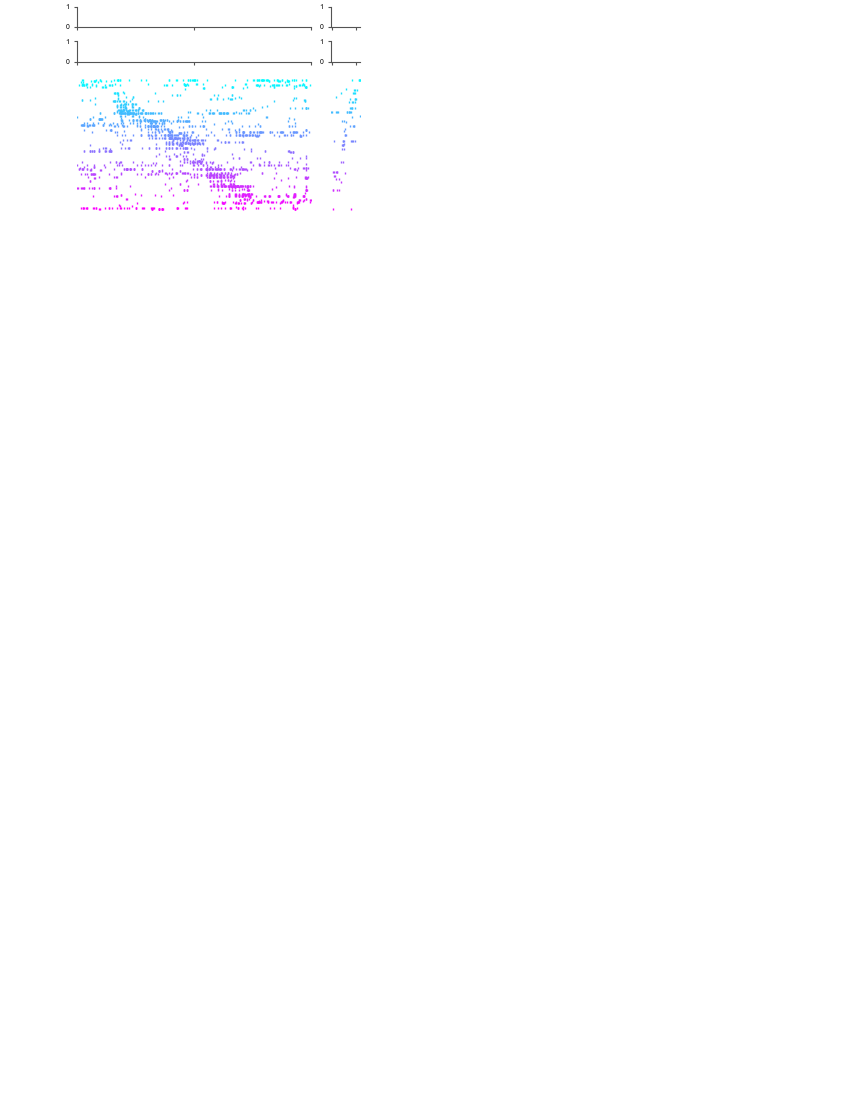

In [13]:
# ---- Choose Period-----
# RatVDay2SD
# run_epoch = [12721, 12]
# pbe = [12722.5, 12723]


# RatUDay2NSD
# run_epoch = [11419, 11430.5]
# pbe = [11420.22, 11420.5]
# run_epoch = [11162, 11172]
# pbe = [11165.5, 11165.79]
run_epoch = [10744, 10760]
# pbe = [10758.1, 10758.55]
pbe = [10753.61, 10753.87]

# RatVDay2SD
# run_epoch = [maze[0] + 1060, maze[0] + 1070]
# pbe = [maze[0] + 1060 + 4.5, maze[0] + 1060 + 4.7]


# run_epoch = maze
run_epoch = [10745.5, 10753.5]
# pbe = [maze[0]+100,maze[0]+100.5]
# pbe = [10753.6, 10753.9]
pbe = [13595.941, 13596.19]
pbe = sess.replay_radon_mua[5821].flatten()
pbe[0] = pbe[0] - 0.025
pbe[1] = pbe[1] + 0.025

# neurons_sorted = neurons.get_by_id(pf.get_sort_order("neuron_id")).time_slice(*run_epoch)
neurons_sorted = neurons.get_by_id(pf.get_sort_order("neuron_id"))
pos_epoch = maze_pos.time_slice(*run_epoch)

cmap = "cool_r"
raster_kw = dict(markersize=2, markeredgewidth=1, rasterized=True)
fig = plotting.Fig(30, 14, tick_size=2, axis_lw=0.8, fontsize=5)
subfig = fig.add_subfigure(fig.gs[0:6, 1:6])
axs = subfig.subplots(
    3, 2, gridspec_kw={"height_ratios": [1, 1, 7], "width_ratios": [8, 1]}, sharex="col"
)


# ---- Running epoch --------
channel = 72

# raster plot
ax = axs[2, 0]
plotting.plot_raster(
    neurons_sorted.time_slice(*run_epoch), color=cmap, ax=ax, **raster_kw
)
ax.set_xticks(np.arange(0, 8.1, 4) + run_epoch[0], np.arange(0, 8.1, 4))
ax.tick_params(rotation=0)
ax.set_yticks([1, len(neurons_sorted)])
sns.despine(ax=ax, trim=True, offset=3)
ax.axis("off")


replay_ax = axs[2, 1]
plotting.plot_raster(
    neurons_sorted.time_slice(*pbe), ax=replay_ax, color=cmap, **raster_kw
)
replay_ax.axis("off")


fig.savefig(subjects.figpath_sd / "example_run", format="png", dpi=300)
# fig.savefig(subjects.figpath_sd / "example_run")

## Explained Variance

### EV for 2 animals 

In [ ]:
from neuropy.core import Epoch

errorbar_kw = dict(alpha=0.5, linewidth=0, ec=None)

grpdata = subjects.GroupData()
ev_df = grpdata.ev_pooled

ev_states = grpdata.ev_brainstates
indx = np.isin(ev_states.name, ["RatN", "RatS"])
ev_states = ev_states[indx]

ev_colors = subjects.colors_sd(0.8)

plt.close()
fig = plotting.Fig(grid=(9, 4))
subfig = fig.add_subfigure(fig.gs[:2, :2])
axs = subfig.subplots(
    4, 2, sharey="row", sharex="col", gridspec_kw=dict(height_ratios=[1, 4, 1, 4])
)

for row, rat in enumerate(["RatN", "RatS"]):
    for col, grp in enumerate(["NSD", "SD"]):
        color = ev_colors[0] if grp == "NSD" else ev_colors[1]

        ax = axs[2 * row, col]
        epoch = Epoch(ev_states[(ev_states.name == rat) & (ev_states.grp == grp)])
        plotting.plot_hypnogram(epoch, ax=ax, collapsed=False)

        ax = axs[2 * row + 1, col]

        df = ev_df[(ev_df.name == rat) & (ev_df.grp == grp)]
        t, ev, ev_err, rev, rev_err = (
            df["Zt"],
            df["ev"],
            df["ev_std"],
            df["rev"],
            df["rev_std"],
        )

        ax.fill_between(t, rev - rev_err, rev + rev_err, color="#33d675", **errorbar_kw)
        ax.plot(t, rev, color="#33d675")
        ax.fill_between(t, ev - ev_err, ev + ev_err, color=color, **errorbar_kw)
        ax.plot(t, ev, color=color)

fig.savefig(subjects.figpath_sd / "example_ev")